In [ ]:
#import libraries
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

This is the new model. In the generator mode, I have added one more Conv2DTranspose layer as well changed the last layer from a Conv2D layer to a Conv2DTranspose layer. I have also changed the activation layer from ReLU to LeakyReLU as the latter works better for DCGANs. In the discriminator model, I have added additional dropout layers to reduce the training time and preventing overfitting.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose

LATENT_DIM = 100 # dimension of the input noise vector
WEIGHT_INIT = 'glorot_uniform' # weight initialization method

def make_generator_model():
    model = Sequential()

    # One fully connected layer: Output size (7*7*256)
    model.add(Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256))) # tensor shape (7x7x256)

    # Upsampling layers
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # last layer with tanh activation function
    model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_60 (LeakyReLU)      │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_61 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 14, 14, 128)    │       409,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_62 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 28, 28, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_63 (LeakyReLU)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,741,376 (10.46 MB)

 Trainable params: 2,715,648 (10.36 MB)

 Non-trainable params: 25,728 (100.50 KB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Flatten, Dense, Dropout

def make_discriminator_model():
    model = Sequential()

    # Conv2D layers
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # last fully connected layer
    model.add(Flatten())
    model.add(Dense(1))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_64 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_65 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,633 (834.50 KB)

 Trainable params: 213,249 (833.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# define the model class
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.gen_loss_list = []
        self.disc_loss_list = []
        # save the min gen and disc error obtained
        self.min_gen_loss = float('inf')
        self.min_disc_loss = float('inf')

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1: Train the discriminator
        with tf.GradientTape() as tape:
            # discriminator loss
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            d_loss = (d_loss_real + d_loss_fake) / 2

        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2: Train the generator
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            # generator loss
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)

        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        # Store the losses
        self.gen_loss_list.append(g_loss.numpy())
        self.disc_loss_list.append(d_loss.numpy())

        # Update minimum losses
        self.min_gen_loss = min(self.min_gen_loss, g_loss.numpy())
        self.min_disc_loss = min(self.min_disc_loss, d_loss.numpy())

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

    def train(self, dataset, epochs):

        num_examples_to_generate = 16
        random_vector_for_generation = tf.random.normal([num_examples_to_generate, self.latent_dim])

        for epoch in range(epochs):
            for image_batch in dataset:
                self.train_step(image_batch)

            print(f'Epoch {epoch + 1}, Generator loss: {self.g_loss_metric.result().numpy()}, Discriminator loss: {self.d_loss_metric.result().numpy()}')
            self.generate_and_save_images(epoch + 1, random_vector_for_generation)

        self.plot_losses()
        print(f'Minimum Generator Loss: {self.min_gen_loss}')
        print(f'Minimum Discriminator Loss: {self.min_disc_loss}')

    def generate_and_save_images(self, epoch, test_input):
        # Generate images from the test input (a fixed set of noise vectors)
        predictions = self.generator(test_input, training=False)

        # Plot the images
        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow((predictions[i, :, :, 0].numpy() * 127.5 + 127.5).astype("uint8"), cmap='gray')
            plt.axis('off')
        plt.show()

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gen_loss_list, label='Generator Loss')
        plt.plot(self.disc_loss_list, label='Discriminator Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


Epoch 1, Generator loss: 0.03758073225617409, Discriminator loss: 0.15189342200756073


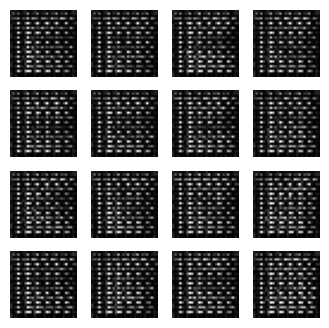

Epoch 2, Generator loss: 0.029231298714876175, Discriminator loss: 0.08115747570991516


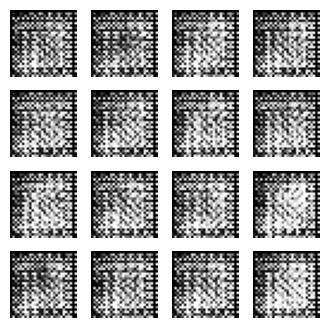

Epoch 3, Generator loss: 0.5165336728096008, Discriminator loss: 0.08929108083248138


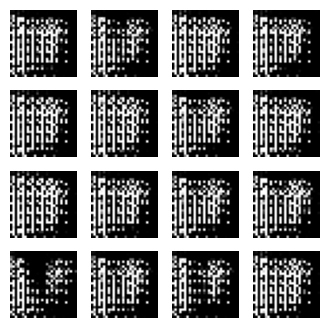

Epoch 4, Generator loss: 0.7249325513839722, Discriminator loss: 0.12055817246437073


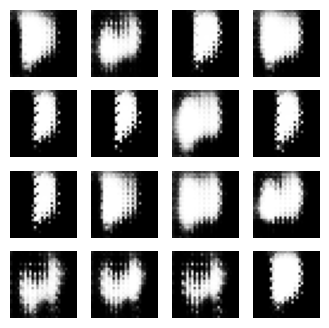

Epoch 5, Generator loss: 0.871171236038208, Discriminator loss: 0.16786865890026093


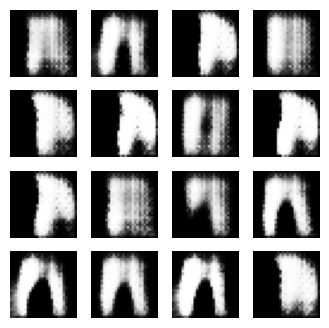

Epoch 6, Generator loss: 1.0496827363967896, Discriminator loss: 0.21230362355709076


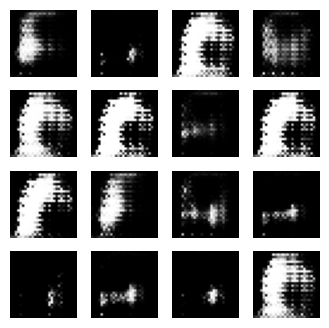

Epoch 7, Generator loss: 1.0089151859283447, Discriminator loss: 0.23482945561408997


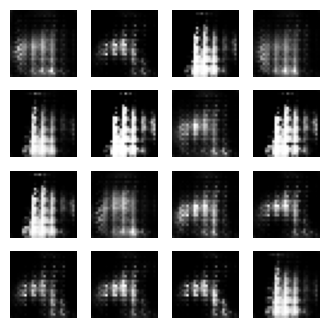

Epoch 8, Generator loss: 1.048453688621521, Discriminator loss: 0.30249935388565063


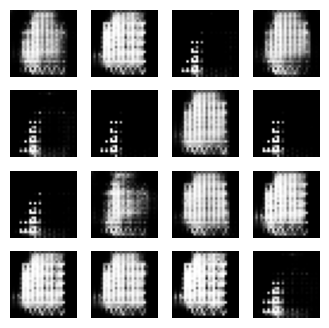

Epoch 9, Generator loss: 1.0584503412246704, Discriminator loss: 0.3411589562892914


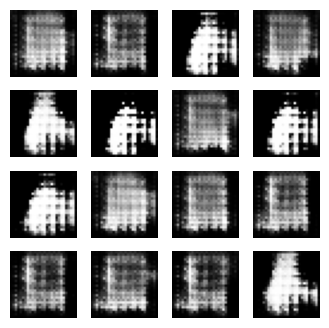

Epoch 10, Generator loss: 1.102737545967102, Discriminator loss: 0.3734421133995056


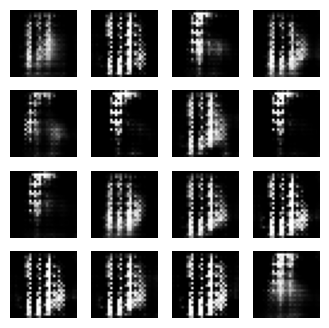

Epoch 11, Generator loss: 1.0790399312973022, Discriminator loss: 0.3741420805454254


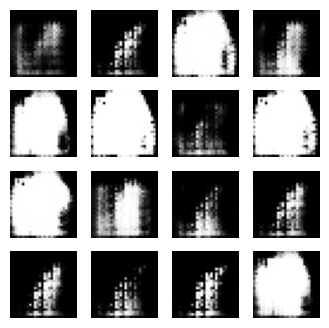

Epoch 12, Generator loss: 1.0807896852493286, Discriminator loss: 0.37471920251846313


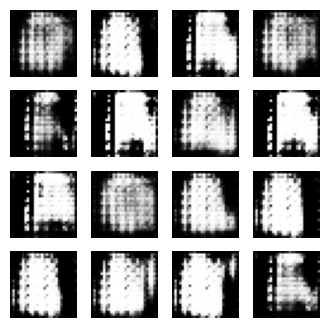

Epoch 13, Generator loss: 1.1078059673309326, Discriminator loss: 0.37513577938079834


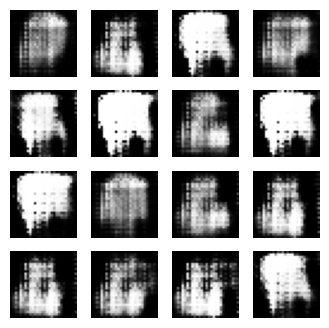

Epoch 14, Generator loss: 1.1247421503067017, Discriminator loss: 0.38822177052497864


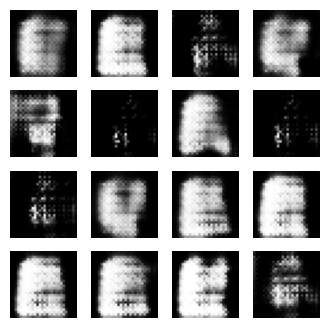

Epoch 15, Generator loss: 1.1522164344787598, Discriminator loss: 0.39116743206977844


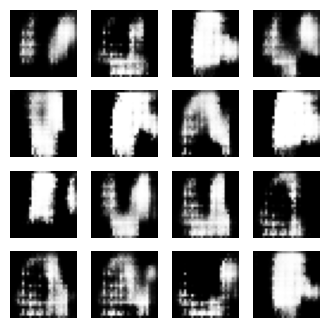

Epoch 16, Generator loss: 1.1602686643600464, Discriminator loss: 0.401653528213501


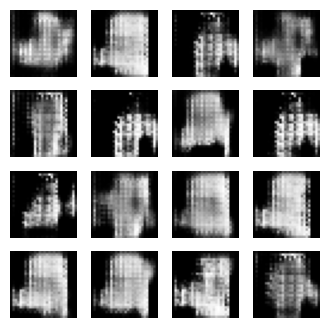

Epoch 17, Generator loss: 1.1721727848052979, Discriminator loss: 0.4104026257991791


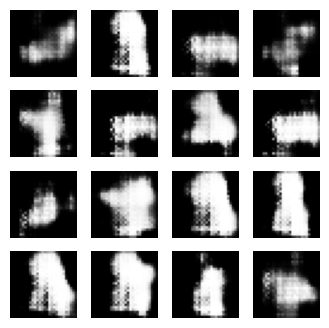

Epoch 18, Generator loss: 1.1890175342559814, Discriminator loss: 0.4088185429573059


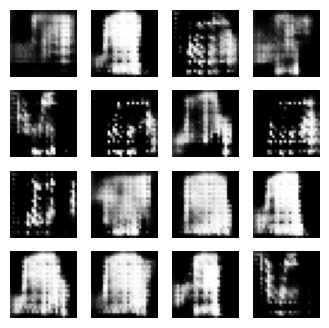

Epoch 19, Generator loss: 1.2020719051361084, Discriminator loss: 0.41442787647247314


Epoch 20, Generator loss: 1.2017179727554321, Discriminator loss: 0.41445261240005493


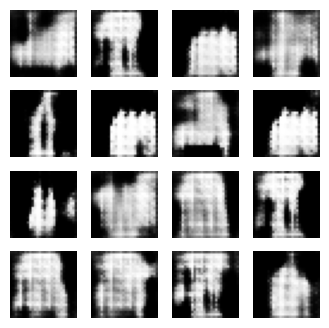

Epoch 21, Generator loss: 1.2018930912017822, Discriminator loss: 0.4129595458507538


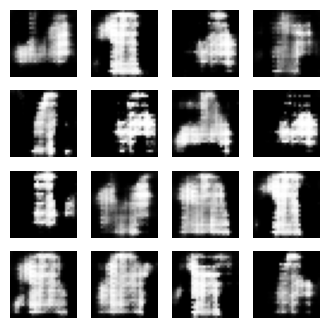

Epoch 22, Generator loss: 1.2086912393569946, Discriminator loss: 0.4120584726333618


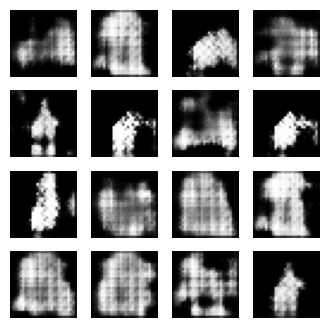

Epoch 23, Generator loss: 1.196753740310669, Discriminator loss: 0.4088990092277527


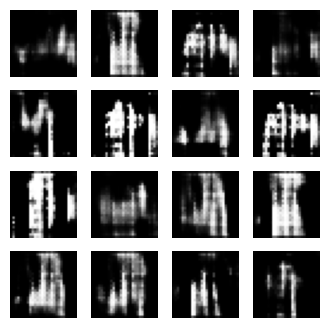

Epoch 24, Generator loss: 1.2074048519134521, Discriminator loss: 0.4045734405517578


Epoch 25, Generator loss: 1.211686134338379, Discriminator loss: 0.40287452936172485


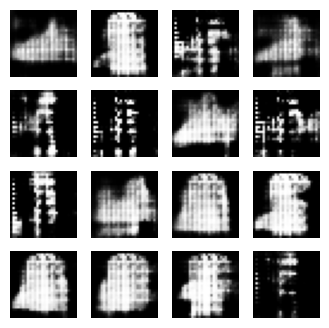

Epoch 26, Generator loss: 1.2217600345611572, Discriminator loss: 0.39779913425445557


Epoch 27, Generator loss: 1.2087821960449219, Discriminator loss: 0.3930068910121918


Epoch 28, Generator loss: 1.23202645778656, Discriminator loss: 0.38945871591567993


Epoch 29, Generator loss: 1.2413125038146973, Discriminator loss: 0.38709020614624023


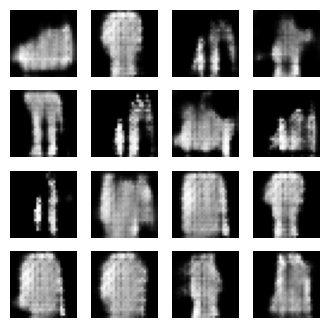

Epoch 30, Generator loss: 1.2532885074615479, Discriminator loss: 0.384709894657135


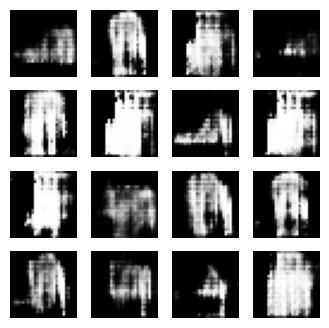

Epoch 31, Generator loss: 1.2563517093658447, Discriminator loss: 0.38282445073127747


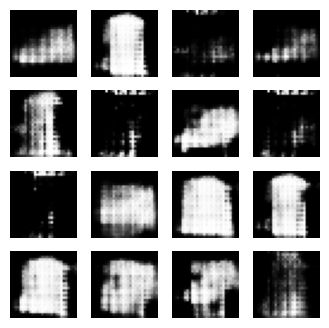

Epoch 32, Generator loss: 1.2737654447555542, Discriminator loss: 0.3790976107120514


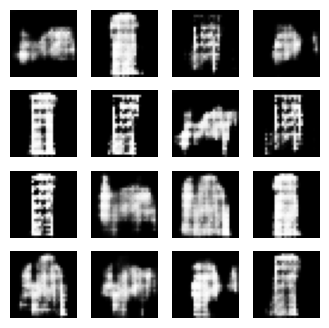

Epoch 33, Generator loss: 1.2638676166534424, Discriminator loss: 0.3762372136116028


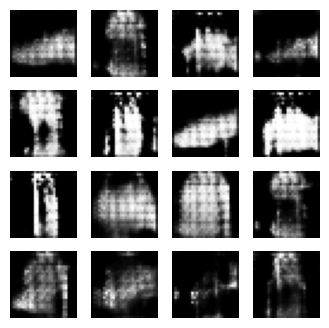

Epoch 34, Generator loss: 1.2835487127304077, Discriminator loss: 0.37339821457862854


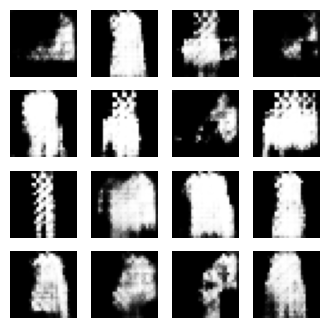

Epoch 35, Generator loss: 1.2923651933670044, Discriminator loss: 0.3739566206932068


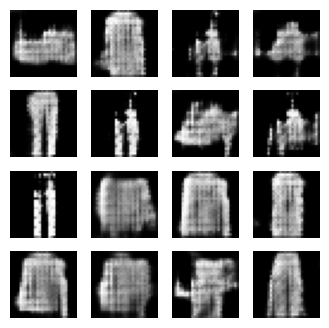

Epoch 36, Generator loss: 1.3010491132736206, Discriminator loss: 0.37382662296295166


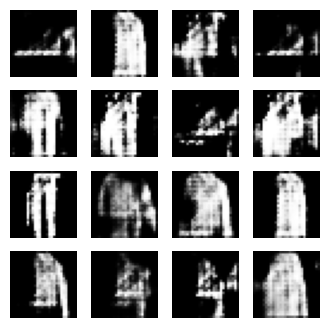

Epoch 37, Generator loss: 1.2915154695510864, Discriminator loss: 0.37215229868888855


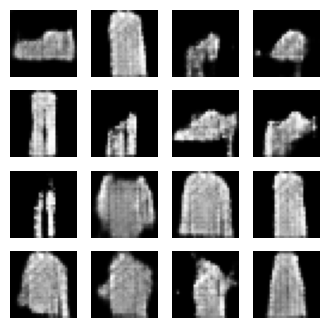

Epoch 38, Generator loss: 1.2832152843475342, Discriminator loss: 0.37075722217559814


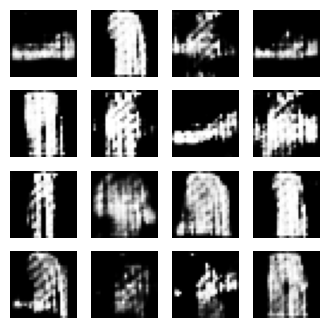

Epoch 39, Generator loss: 1.2748279571533203, Discriminator loss: 0.3679000437259674


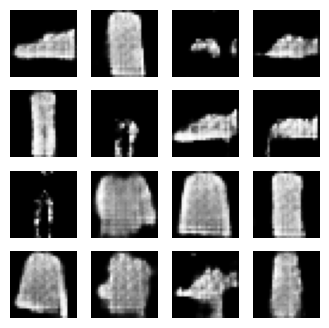

Epoch 40, Generator loss: 1.2761809825897217, Discriminator loss: 0.3677191436290741


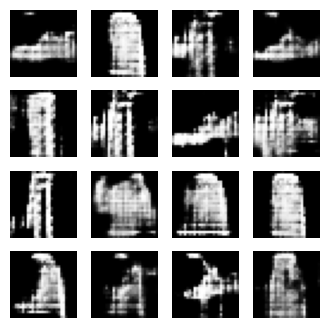

Epoch 41, Generator loss: 1.2796411514282227, Discriminator loss: 0.3682715892791748


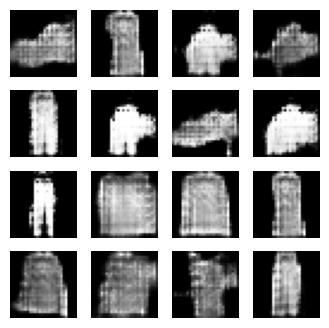

Epoch 42, Generator loss: 1.2806153297424316, Discriminator loss: 0.36623573303222656


Epoch 43, Generator loss: 1.2766207456588745, Discriminator loss: 0.36382654309272766


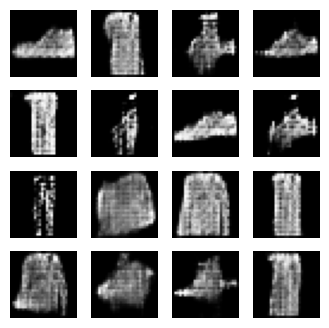

Epoch 44, Generator loss: 1.2668325901031494, Discriminator loss: 0.36415567994117737


Epoch 45, Generator loss: 1.2532833814620972, Discriminator loss: 0.36043962836265564


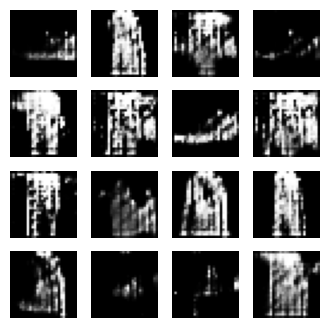

Epoch 46, Generator loss: 1.2525421380996704, Discriminator loss: 0.35771292448043823


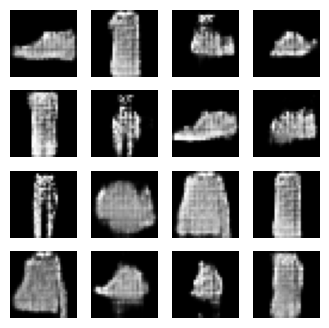

Epoch 47, Generator loss: 1.2445871829986572, Discriminator loss: 0.3583284318447113


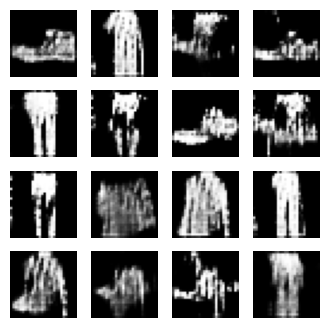

Epoch 48, Generator loss: 1.2428981065750122, Discriminator loss: 0.35966891050338745


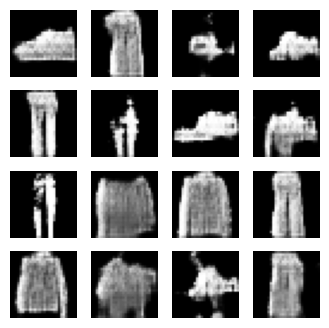

Epoch 49, Generator loss: 1.2310017347335815, Discriminator loss: 0.3588862419128418


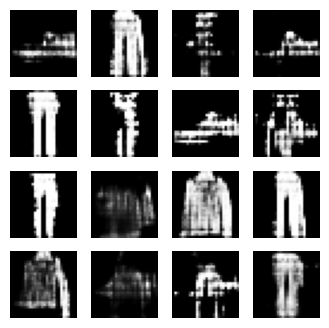

Epoch 50, Generator loss: 1.2171001434326172, Discriminator loss: 0.3564128279685974


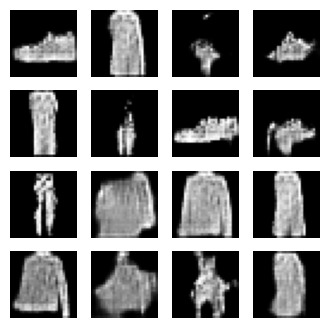

Minimum Generator Loss: 0.0011186159681528807
Minimum Discriminator Loss: 0.0032462161034345627


In [ ]:
# Load and preprocess the dataset
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Initialize the DCGAN
dcgan = DCGAN(
    discriminator=make_discriminator_model(),
    generator=make_generator_model(),
    latent_dim=LATENT_DIM
)

# Compile the model
dcgan.compile(
    d_optimizer=Adam(1e-4),
    g_optimizer=Adam(1e-4),
    loss_fn=BinaryCrossentropy(from_logits=True)
)

# Train the model
dcgan.train(train_dataset, epochs=50)

These are the loss curves obtained for the new model. The curves do not show any significant pattern indicating that the DCGAN model was highly unstable during training. The overall range of generator and discriminator losses has been increased as compared to the old model but the minimum losses observed have gone down.

This is the old model. I found this model online and changed few layers and added one more layer to make the new model.

In [ ]:
LATENT_DIM = 100
WEIGHT_INIT = 'glorot_uniform'

def build_generator():
    # create a Keras Sequential model
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(1, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [ ]:
# build the discriminator model
generator = build_generator()
discriminator = build_discriminator(28, 28, 1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1, Generator loss: 0.11799974739551544, Discriminator loss: 0.20968890190124512


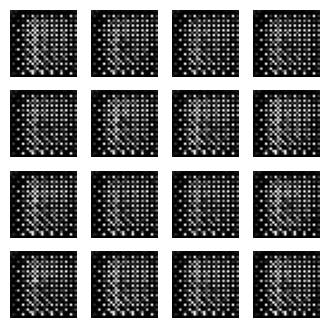

Epoch 2, Generator loss: 0.2004263997077942, Discriminator loss: 0.1598268449306488


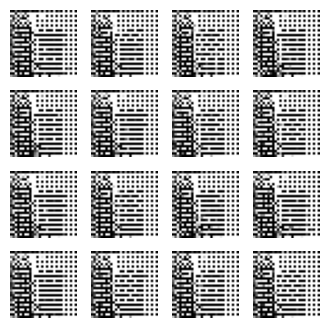

Epoch 3, Generator loss: 0.42989516258239746, Discriminator loss: 0.17417509853839874


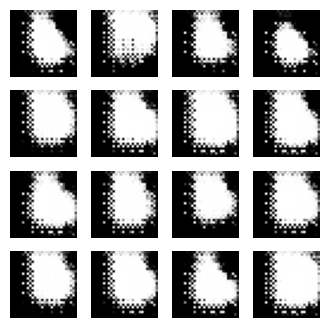

Epoch 4, Generator loss: 0.6247724890708923, Discriminator loss: 0.2464340329170227


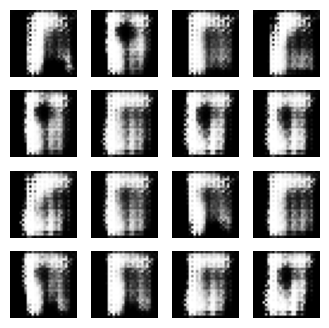

Epoch 5, Generator loss: 0.7921565771102905, Discriminator loss: 0.31781309843063354


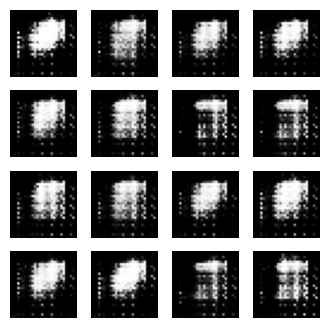

Epoch 6, Generator loss: 0.9398970603942871, Discriminator loss: 0.3482208549976349


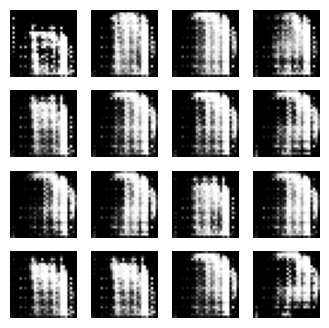

Epoch 7, Generator loss: 0.9906103014945984, Discriminator loss: 0.3950258791446686


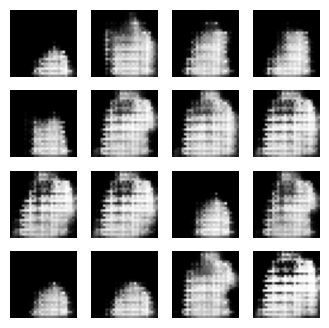

Epoch 8, Generator loss: 1.0348657369613647, Discriminator loss: 0.4419567883014679


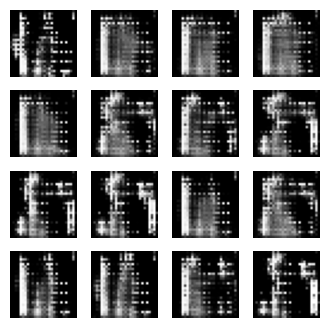

Epoch 9, Generator loss: 1.060272455215454, Discriminator loss: 0.4489038586616516


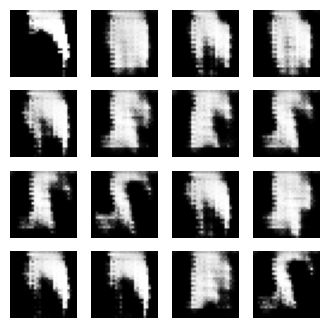

Epoch 10, Generator loss: 1.0874406099319458, Discriminator loss: 0.4770495295524597


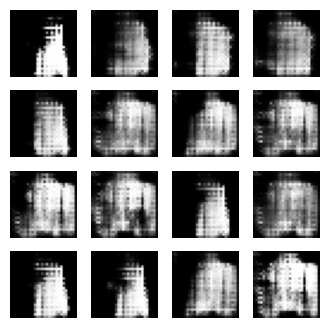

Epoch 11, Generator loss: 1.1011037826538086, Discriminator loss: 0.4950028955936432


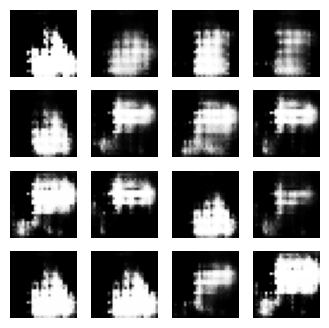

Epoch 12, Generator loss: 1.1196751594543457, Discriminator loss: 0.49789851903915405


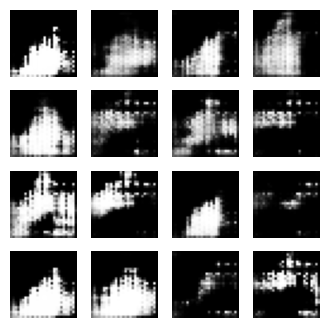

Epoch 13, Generator loss: 1.1590827703475952, Discriminator loss: 0.4967779815196991


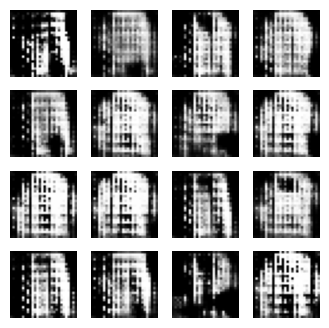

Epoch 14, Generator loss: 1.1633777618408203, Discriminator loss: 0.48989346623420715


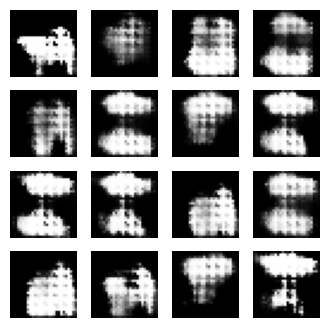

Epoch 15, Generator loss: 1.1706674098968506, Discriminator loss: 0.5000794529914856


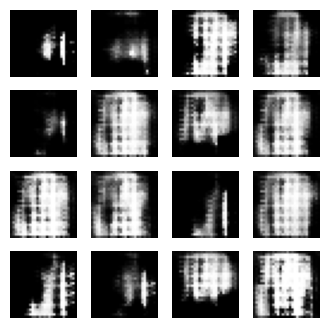

Epoch 16, Generator loss: 1.173604130744934, Discriminator loss: 0.5070924758911133


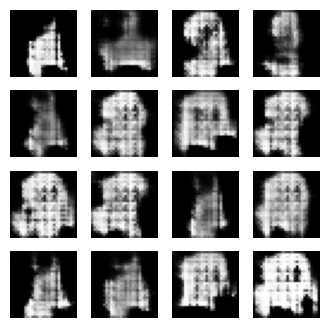

Epoch 17, Generator loss: 1.1766527891159058, Discriminator loss: 0.5106858611106873


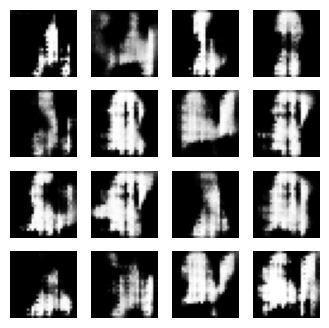

Epoch 18, Generator loss: 1.1803196668624878, Discriminator loss: 0.5128917694091797


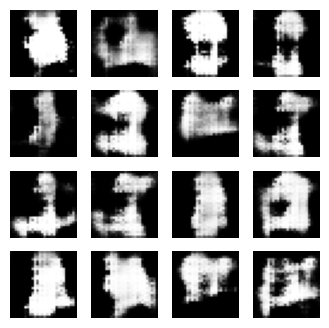

Epoch 19, Generator loss: 1.184801697731018, Discriminator loss: 0.5137287378311157


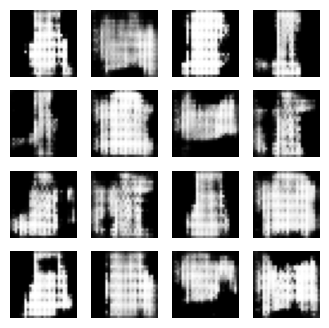

Epoch 20, Generator loss: 1.1809031963348389, Discriminator loss: 0.5114124417304993


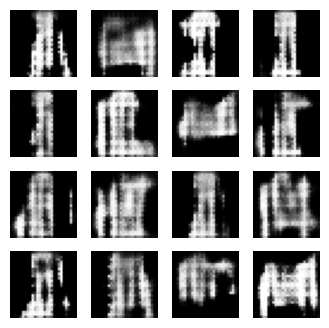

Epoch 21, Generator loss: 1.1936967372894287, Discriminator loss: 0.5085173845291138


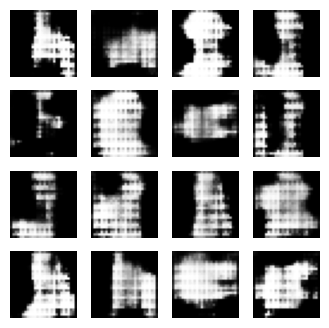

Epoch 22, Generator loss: 1.1861944198608398, Discriminator loss: 0.5056282877922058


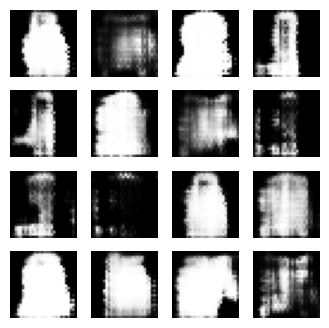

Epoch 23, Generator loss: 1.1894786357879639, Discriminator loss: 0.5001285672187805


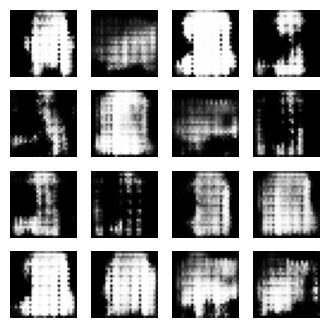

Epoch 24, Generator loss: 1.2136757373809814, Discriminator loss: 0.4969485402107239


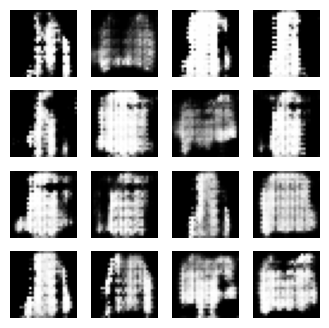

Epoch 25, Generator loss: 1.2164461612701416, Discriminator loss: 0.4954906105995178


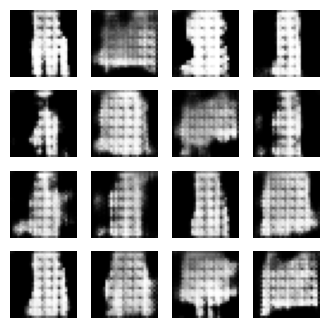

Epoch 26, Generator loss: 1.2143059968948364, Discriminator loss: 0.4895951747894287


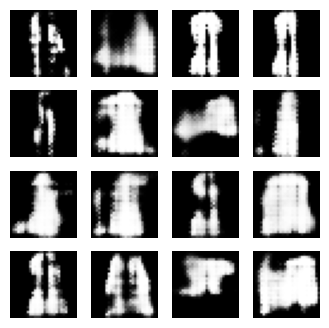

Epoch 27, Generator loss: 1.2169196605682373, Discriminator loss: 0.4838208854198456


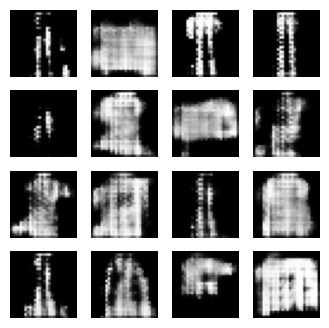

Epoch 28, Generator loss: 1.2358078956604004, Discriminator loss: 0.4789147973060608


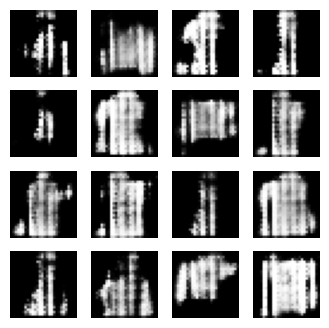

Epoch 29, Generator loss: 1.2480804920196533, Discriminator loss: 0.4771089553833008


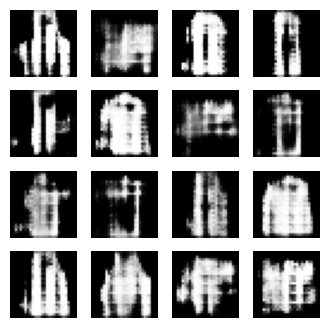

Epoch 30, Generator loss: 1.2619746923446655, Discriminator loss: 0.47346052527427673


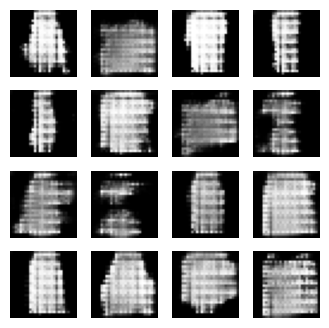

Epoch 31, Generator loss: 1.2660887241363525, Discriminator loss: 0.46723780035972595


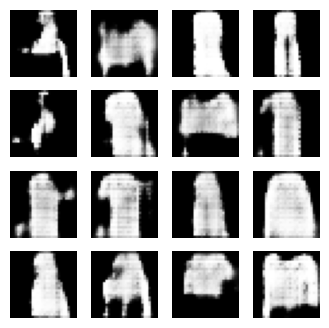

Epoch 32, Generator loss: 1.2823736667633057, Discriminator loss: 0.4633808434009552


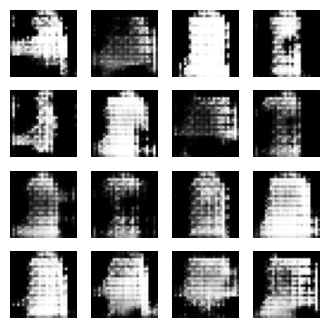

Epoch 33, Generator loss: 1.30030357837677, Discriminator loss: 0.454622358083725


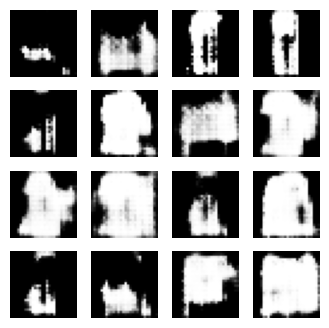

Epoch 34, Generator loss: 1.308822751045227, Discriminator loss: 0.4512961804866791


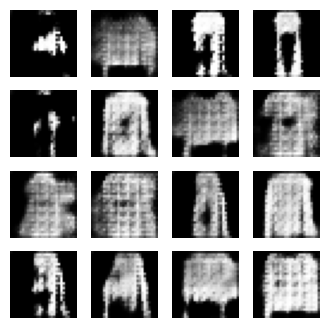

Epoch 35, Generator loss: 1.3168282508850098, Discriminator loss: 0.4459500312805176


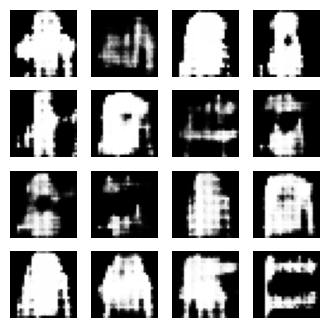

Epoch 36, Generator loss: 1.3136141300201416, Discriminator loss: 0.4393996298313141


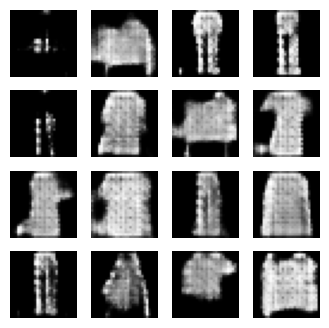

Epoch 37, Generator loss: 1.3253304958343506, Discriminator loss: 0.4348704218864441


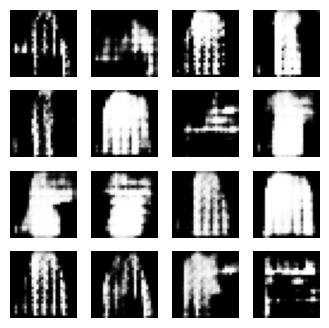

Epoch 38, Generator loss: 1.3466532230377197, Discriminator loss: 0.4299447536468506


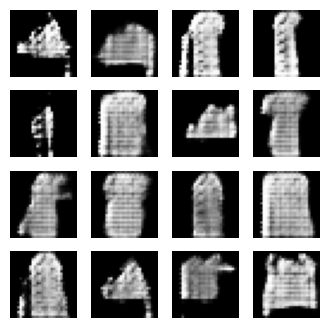

Epoch 39, Generator loss: 1.3528612852096558, Discriminator loss: 0.4286191463470459


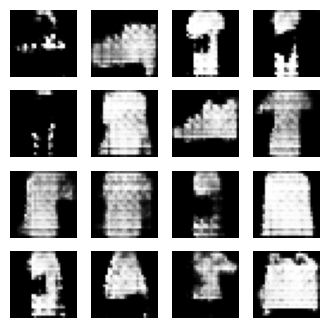

Epoch 40, Generator loss: 1.3558717966079712, Discriminator loss: 0.4265485405921936


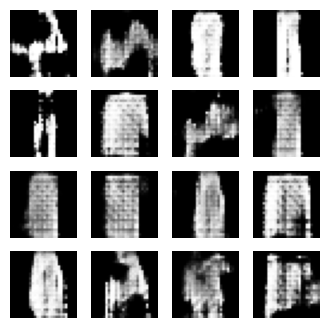

Epoch 41, Generator loss: 1.357041597366333, Discriminator loss: 0.4241829812526703


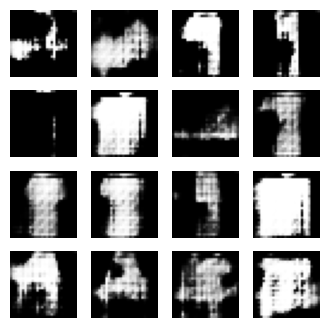

Epoch 42, Generator loss: 1.3677514791488647, Discriminator loss: 0.42070791125297546


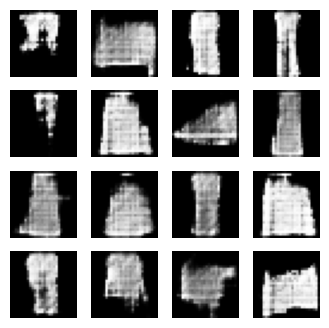

Epoch 43, Generator loss: 1.360673189163208, Discriminator loss: 0.41823190450668335


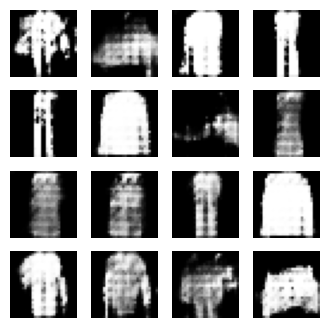

Epoch 44, Generator loss: 1.369512915611267, Discriminator loss: 0.414202481508255


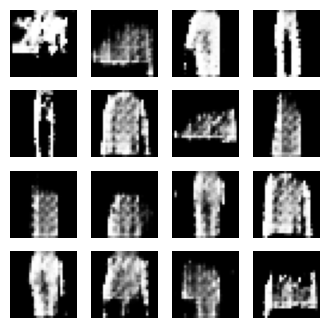

Epoch 45, Generator loss: 1.3651012182235718, Discriminator loss: 0.4127604067325592


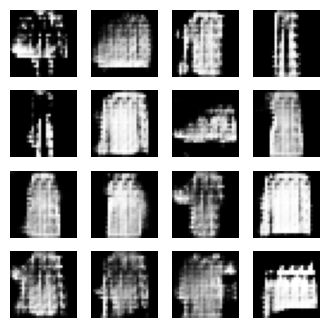

Epoch 46, Generator loss: 1.3683134317398071, Discriminator loss: 0.4096292555332184


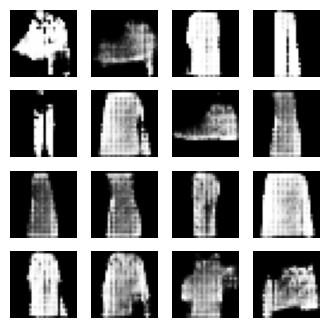

Epoch 47, Generator loss: 1.367522954940796, Discriminator loss: 0.40883418917655945


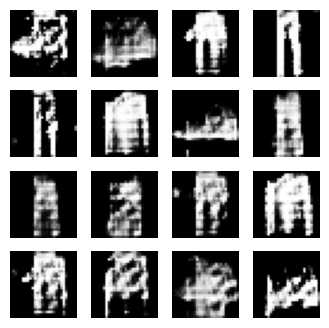

Epoch 48, Generator loss: 1.369665503501892, Discriminator loss: 0.40761277079582214


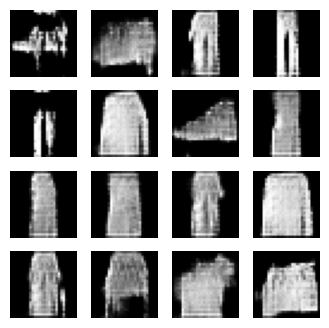

Epoch 49, Generator loss: 1.3715752363204956, Discriminator loss: 0.40718385577201843


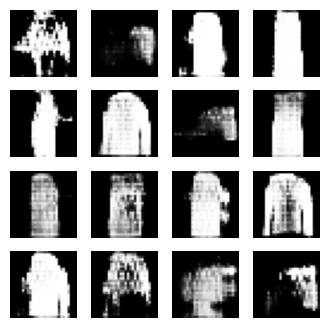

Epoch 50, Generator loss: 1.3687586784362793, Discriminator loss: 0.4064420163631439


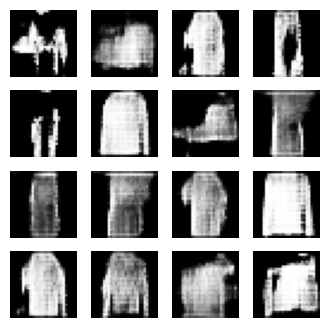

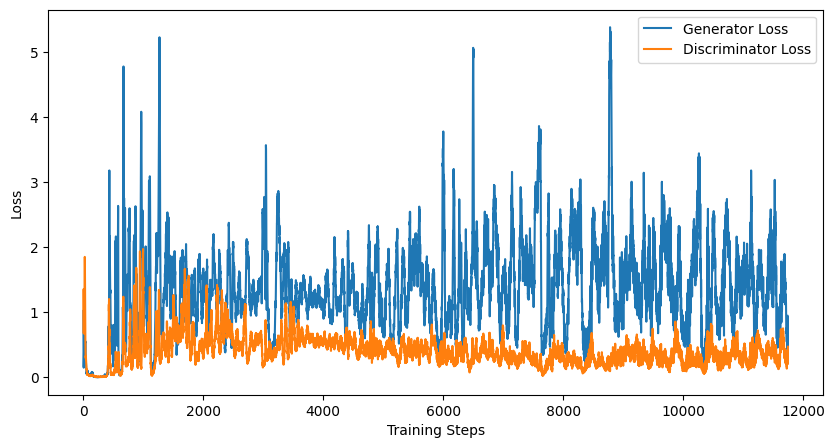

Minimum Generator Loss: 0.0038790267426520586
Minimum Discriminator Loss: 0.0051173255778849125


In [ ]:
# Load and preprocess the dataset
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Initialize the DCGAN
dcgan = DCGAN(
    discriminator=make_discriminator_model(),
    generator=make_generator_model(),
    latent_dim=LATENT_DIM
)

# Compile the model
dcgan.compile(
    d_optimizer=Adam(1e-4),
    g_optimizer=Adam(1e-4),
    loss_fn=BinaryCrossentropy(from_logits=True)
)

# Train the model
dcgan.train(train_dataset, epochs=50)

These are the results obtained for the old model. There is no significant pattern obtained in curves of both generator and discriminator losses. The curve shows that the DCGAN model was very unstable during training.

The minimum error obtained for the new model's generator and discriminator is much lower than that for the old model; minimum generator loss is lowered by around 71% and minimum discrimintor loss is lowered by around 37%. If we observe the image generated by the models in the last epoch, we can see that the new model can generate distinct shoes and shirts and maybe a bit of pants whereas the old model ends up generating images which are very similar and all images look like shirts. So our model has gotten a little better by adding a new Conv2DTranspose layer and changing some other layers.

Image generated by old model on the last epoch:
Screenshot 2024-06-20 053434.png

Image generated by new model on the last epoch:
Screenshot 2024-06-20 053414.png